- When identifying Italians and Germans, we need to look at the same repositories in both time periods. Can we add this to the Italian Identification?
- For the Metrics: normalize values  to the range of 0% (lowest) and 100% (highest)
- Current analysis is good for an overview but for the DiD it needs to be in panel data format not grouped only by repositories

#### Papers using same approach
- Hasabnis, N. (2022). GitRank: A Framework to Rank GitHub Repositories. Proceedings - 2022 Mining Software Repositories Conference, MSR 2022, 729–731. https://doi.org/10.1145/3524842.3528519 


# Dependent Variable: Collaboration

#### Has the introduction of ChatGPT increased collaboration among Software Developers?
1. Contribution >> Count Forks
2. Commit Frequency >> Count push/pull Events
3. Commit diversity >> count unique contributers per repository

# Key Takeaways - Data Distribution

#### Concentration of Activity, Skewed Distribution, Disparate Engagement
- Significant centralization within a few repositories, coupled with a high degree of data asymmetry, highlighting both selectivity in community engagement and a disproportionate focus on a minimal number of projects. 
- Predominance of repositories with minimal activity, indicating that numerous projects may be personal, experimental, or in early stages of development.

#### Implications
- Applying stratified sampling techniques, such as categorizing repositories into high/medium/low-activity segments, alongside employing specialized statistical methodologies tailored for skewed distributions. 
- Prioritizing data filtering and robust analytical techniques to differentiate dormant or less popular projects from those with genuine user engagement, ensuring the research focuses on meaningful activity without being overwhelmed by the volume of low-activity data.

In [13]:
import pandas as pd
import json
import gzip
import io
import time
from github import Github
import fuzzywuzzy
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import requests
import os
import sys
from config import config
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

#### Import Sample from GitHub Archive, Display Data Structure and Group by Repository
- Sample of 1.3mio commits
- pre gpt = 01.04.2022, 15:00-18:00
- post gpt = 01.04.2023, 15:00-18:00


In [2]:
access_token = config.ACCESS_TOKEN
github_token = config.GITHUB_TOKEN

In [3]:
# Ensure the 'data' folder exists
if not os.path.exists('data'):
    os.makedirs('data')
    
start = datetime(2022, 4, 1, 15)  # year, month, day, hour
end = datetime(2022, 4, 1, 18)  # year, month, day, hour

# Generate the hours between the start and end dates
hours = int((end - start).total_seconds() / 3600)
dates = [start + timedelta(hours=i) for i in range(hours + 1)]  # '+1' to include the end hour

# Download the data for each hour in the range and skip download if the file already exists
for date in dates:
    date_str = date.strftime('%Y-%m-%d-%H')
    url = f'https://data.gharchive.org/{date_str}.json.gz'
    file_path = os.path.join('data', f'{date_str}.json.gz')
    
    if os.path.exists(file_path):
        print(f"The file already exists at {file_path}. No need to download.")
        continue

    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=128):
                file.write(chunk)
        print(f"File downloaded successfully and saved to {file_path}")
    else:
        print("Failed to fetch the file")

The file already exists at data\2022-04-01-15.json.gz. No need to download.
The file already exists at data\2022-04-01-16.json.gz. No need to download.
The file already exists at data\2022-04-01-17.json.gz. No need to download.
The file already exists at data\2022-04-01-18.json.gz. No need to download.


In [6]:
file_names = [
    '2022-04-01-15.json.gz', 
    '2022-04-01-16.json.gz',
    '2022-04-01-17.json.gz',
    '2022-04-01-18.json.gz',
    '2023-04-01-15.json.gz', 
    '2023-04-01-16.json.gz',
    '2023-04-01-17.json.gz',
    '2023-04-01-18.json.gz',
]
all_data = [] 
def process_file(file_path):
    data_list = []    
    with gzip.open(file_path, 'r') as f:
        for line in f:
            if isinstance(line, bytes):
                line = line.decode('utf-8')
            data = json.loads(line)
            # DELETE FOR ACTUAL ANALYSIS; Remove the 'payload' key-value pair from the dictionary, only to make it quicker for now
            data.pop('payload', None)
            data_list.append(data)
    df = pd.DataFrame(data_list)
    return df
# Process each file
for file_name in file_names:
    file_path = os.path.join('data', file_name)
    
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path}")
        continue
    print(f"Processing file: {file_path}")
    current_df = process_file(file_path)
    all_data.append(current_df) 

# Concatenate all the data into a single DataFrame
final_df = pd.concat(all_data, ignore_index=True)
print("All files have been processed and combined.")

Processing file: data\2022-04-01-15.json.gz
Processing file: data\2022-04-01-16.json.gz
Processing file: data\2022-04-01-17.json.gz
Processing file: data\2022-04-01-18.json.gz
Processing file: data\2023-04-01-15.json.gz
Processing file: data\2023-04-01-16.json.gz
Processing file: data\2023-04-01-17.json.gz
Processing file: data\2023-04-01-18.json.gz
All files have been processed and combined.


In [9]:
final_df.head()

,id,type,actor,repo,public,created_at,org
0,21067017389,PushEvent,"{'id': 101735524, 'login': 'rashel9454', 'disp...","{'id': 475677195, 'name': 'rashel9454/class3as...",True,2022-04-01T15:00:00Z,NaN
1,21067017424,PushEvent,"{'id': 60771195, 'login': 'Avinaw', 'display_l...","{'id': 259306531, 'name': 'Avinaw/docker-alpin...",True,2022-04-01T15:00:00Z,NaN
2,21067017426,CreateEvent,"{'id': 3775910, 'login': 'v-rudkovskiy', 'disp...","{'id': 99856885, 'name': 'Labs64/NetLicensingC...",True,2022-04-01T15:00:00Z,"{'id': 1461983, 'login': 'Labs64', 'gravatar_i..."
3,21067017428,DeleteEvent,"{'id': 30536864, 'login': 'signcla-test-signed...","{'id': 409344435, 'name': 'google-test2/signcl...",True,2022-04-01T15:00:00Z,"{'id': 9579519, 'login': 'google-test2', 'grav..."
4,21067017438,PushEvent,"{'id': 3743002, 'login': 'mrz1836', 'display_l...","{'id': 457427881, 'name': 'BuxOrg/bux', 'url':...",True,2022-04-01T15:00:00Z,"{'id': 98559231, 'login': 'BuxOrg', 'gravatar_..."


### Prepare Data for DiD >> transform to panel data

Additional columns needed
- time_id: indicates the hour (instead of the more granular "created_at" variable
- gpt: "pre" if before GPT introduction or "post" if after GPT introduction
- treatment: is either 0 if control group or 1 if treatment group (currently randomly assigned, to be combined with italy approach once done)

In [14]:
commits = final_df

commits['created_at'] = pd.to_datetime(commits['created_at'])
commits['time_id'] = commits['created_at'].dt.strftime('%d.%m.%Y, %H:00')

# Calculate metrics for each commit
commits['is_fork'] = commits['type'] == 'ForkEvent'
commits['is_push'] = commits['type'] == 'PushEvent'
commits['is_pull'] = commits['type'] == 'PullRequestEvent'

# Create a 'Treatment' column and randomly assign 0 or 1
commits['Treatment'] = np.random.randint(2, size=len(commits))

# Selecting necessary columns to form the final panel data
if 'actor' in commits.columns:
    commits['actor_login'] = commits['actor'].apply(lambda x: x.get('login') if isinstance(x, dict) else np.nan)
# Extracting 'name' from the nested 'repo' dictionary (similar to 'actor_login')
if 'repo' in commits.columns:
    commits['repo_name'] = commits['repo'].apply(lambda x: x.get('name') if isinstance(x, dict) else np.nan)
panel_data_columns = ['time_id', 'Treatment', 'is_fork', 'is_push', 'is_pull', 'actor_login', 'repo_name']  # Adjusted columns
panel_data = commits[panel_data_columns]

panel_data.head()
                                       
# If you want to keep track of unique contributors and total contributions, you might need to do additional groupby operations.
# For now, let's keep it simple and assume each row is a unique contribution.

,time_id,Treatment,is_fork,is_push,is_pull,actor_login,repo_name
0,"01.04.2022, 15:00",0,False,True,False,rashel9454,rashel9454/class3asainment-
1,"01.04.2022, 15:00",0,False,True,False,Avinaw,Avinaw/docker-alpine-nginx
2,"01.04.2022, 15:00",1,False,False,False,v-rudkovskiy,Labs64/NetLicensingClient-javascript
3,"01.04.2022, 15:00",0,False,False,False,signcla-test-signed-indiv,google-test2/signclav2-probe-repo
4,"01.04.2022, 15:00",0,False,True,False,mrz1836,BuxOrg/bux


In [16]:
panel = panel_data


,Treatment
count,1.285782e+06
mean,5.000964e-01
std,5.000002e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [20]:
#check number of unique timestamps
panel_data['time_id'].value_counts()

2022-04-01 15:00:00    171846
2022-04-01 16:00:00    170391
2023-04-01 15:00:00    162887
2022-04-01 17:00:00    161588
2022-04-01 18:00:00    157961
2023-04-01 17:00:00    154759
2023-04-01 16:00:00    154185
2023-04-01 18:00:00    152165
Name: time_id, dtype: int64

C:\Users\Kim\AppData\Local\Temp\ipykernel_16064\4248128868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_data['time_id'] = pd.to_datetime(panel_data['time_id'], format='%d.%m.%Y, %H:%M')
C:\Users\Kim\AppData\Local\Temp\ipykernel_16064\4248128868.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_data['time_id'] = panel_data['time_id'].dt.strftime('%d.%m.%Y, %H:%M')


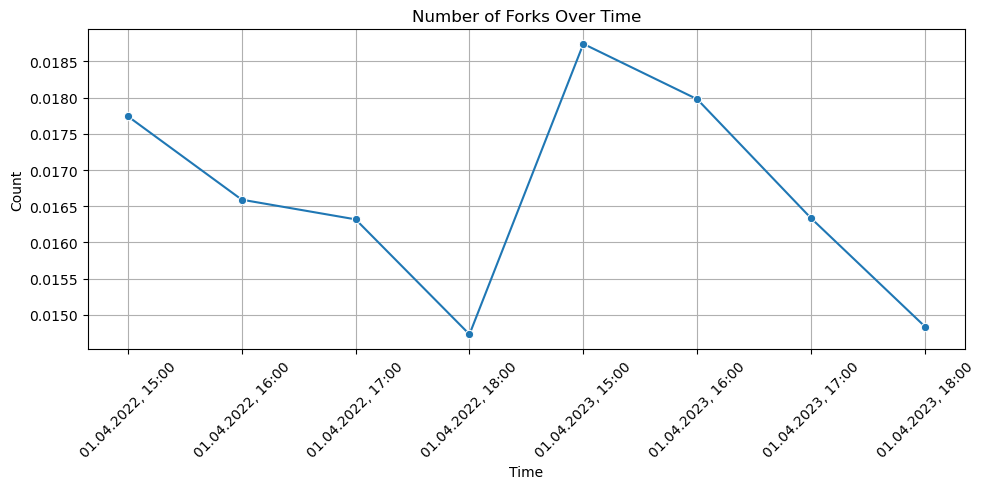

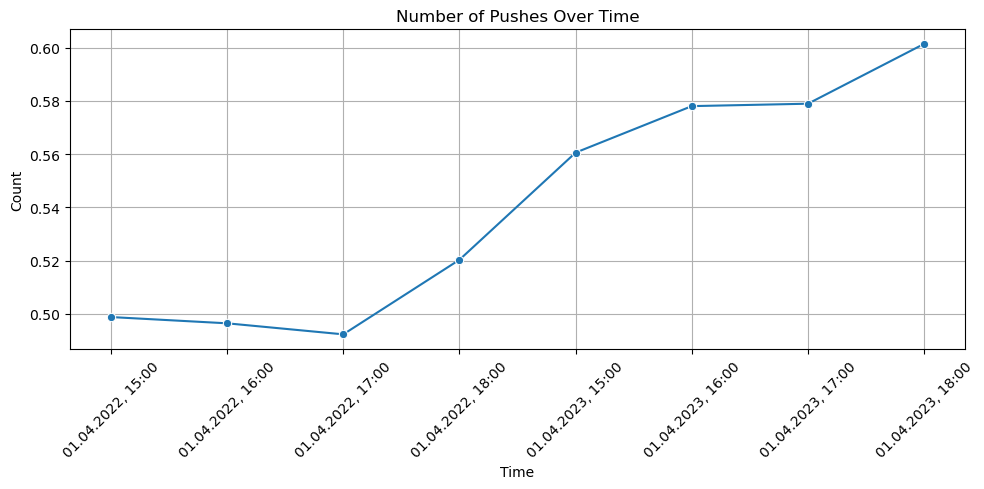

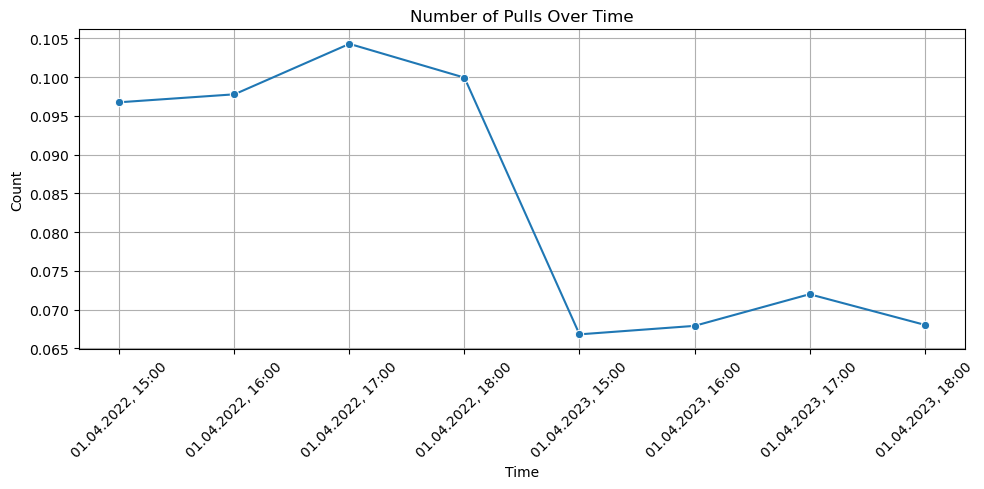

In [28]:
# Check if 'time_id' is not of datetime dtype and convert if necessary
if not pd.api.types.is_datetime64_any_dtype(panel_data['time_id']):
    panel_data['time_id'] = pd.to_datetime(panel_data['time_id'], format='%d.%m.%Y, %H:%M')
panel_data['time_id'] = panel_data['time_id'].dt.strftime('%d.%m.%Y, %H:%M')
panel_data = panel_data.copy()

# Group the data by 'time_id' and calculate the average of each event type
grouped = panel_data.groupby('time_id').agg({'is_fork': 'mean', 'is_push': 'mean', 'is_pull': 'mean'})
grouped.reset_index(inplace=True)

metrics = ['is_fork', 'is_push', 'is_pull']
titles = ['Number of Forks Over Time', 'Number of Pushes Over Time', 'Number of Pulls Over Time']

for metric, title in zip(metrics, titles):
    plt.figure(figsize=(10, 5))
    sns.lineplot(x='time_id', y=metric, data=grouped, marker='o', sort=False)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# pd.json_normalize(commits['actor'])

In [ ]:
# pd.json_normalize(commits['repo'])

In [ ]:
# pd.json_normalize(df['org'])

## Calculate different metrics to measure collaboration on repository-level and store in new df 'repos'

In [30]:
# Extracting repository name and id for easy grouping
commits['repo_name'] = commits['repo'].apply(lambda x: x['name'])
commits['repo_id'] = commits['repo'].apply(lambda x: x['id'])
commits['actor_login'] = commits['actor'].apply(lambda x: x['login'])

# Calculating metrics
grouped = commits.groupby(['repo_name', 'repo_id'])

forks_per_repo = grouped.apply(lambda x: (x['type'] == 'ForkEvent').sum())
push_per_repo = grouped.apply(lambda x: (x['type'] == 'PushEvent').sum())
pull_per_repo = grouped.apply(lambda x: (x['type'] == 'PullRequestEvent').sum())
unique_contributors_per_repo = grouped['actor_login'].nunique()
total_contributors_per_repo = grouped['actor_login'].size()

# Combining metrics into a new dataframe
repos = pd.DataFrame({
    'Forks': forks_per_repo,
    'Pushes': push_per_repo,
    'Pulls': pull_per_repo,
    'UniqueContributors': unique_contributors_per_repo,
    'TotalContributions': total_contributors_per_repo,
}).reset_index()
repos.head()

KeyboardInterrupt: 

In [ ]:
repos.describe()

### Visualisations

In [ ]:
sns.set_theme(style="whitegrid")
metrics = ['Forks', 'Pushes', 'Pulls', 'UniqueContributors', 'TotalContributions']
for metric in metrics:
    plt.figure(figsize=(12, 6))
    value_counts = repos[metric].value_counts().sort_index()
    plt.scatter(value_counts.index, value_counts.values, alpha=0.5, color='navy')
    plt.title(f'Repositories Distribution by Number of {metric}', fontsize=20)
    plt.xlabel(f'Number of {metric} (in a Repository)', fontsize=20)
    plt.ylabel(f'Number of Repositories', fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(17, 3 * len(metrics)))  

for index, metric in enumerate(metrics):
    plt.subplot(len(metrics), 2, 2*index + 2)
    repos_sorted = repos.sort_values(by=metric, ascending=False)
    repos_sorted.set_index('repo_name').head(5)[metric].plot(kind='bar', color=light_blue)
    plt.title(f'Top 5 Repos by {metric}')
    plt.ylabel('Count')
    plt.xticks(rotation=20)
    
plt.tight_layout()
plt.show()

In [ ]:
sns.set_palette("light:#B0C4DE")

for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.heatmap(repos.pivot_table(index='repo_name', values=metric, aggfunc='sum').sort_values(by=metric, ascending=False).head(20), annot=True, fmt="g", cmap='Blues', linewidths=.5)
    plt.title(f'Heatmap for {metric}')
    plt.tight_layout()
    plt.show()